In [37]:
import torch
from torch.nn import functional as F
from torch import nn 
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np 
import random
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm


%matplotlib inline 

# set seed for replicable results 
torch.manual_seed(999)
random.seed(10)

In [38]:
image_path = "data/abstract_art/"
image_size = (64, 64)
batch_size = 32
latent_size = 100
epoch_restore = 150
checkpoint_path = "data/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

lr = 0.0002
beta1 = 0.5
epochs = 60

# we read the image data and preprocess it 

dataset = ImageFolder(root=image_path,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.ToTensor(),
                               # normalize to the range [-1, 1]
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# create a dataloader 
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [39]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [40]:
# getting a batch from the dataloader 
batch = next(iter(dataloader))

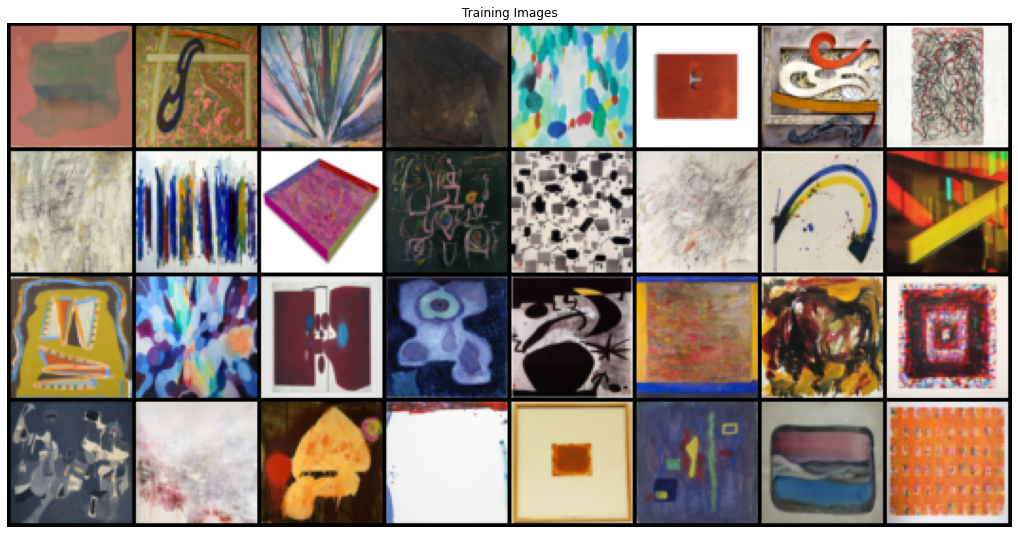

In [41]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")

# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

In [42]:
# custom weights initialization based on the 2015 DCGAN paper 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [43]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [44]:
generator = Generator().to(device)
generator.apply(weights_init)

# calculate the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(generator)
print("Trainable Parameters:", count_parameters(generator))

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Trainable Parameters: 3576704


In [45]:
untrained_output = generator(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)

torch.Size([1, 3, 64, 64])


In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [47]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print(discriminator)
print("Trainable Parameters:", count_parameters(discriminator))

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Trainable Parameters: 2765568


In [48]:
discriminator(untrained_output).view(-1).detach()

tensor([0.4898])

In [49]:
# cross binary entropy
criterion = nn.BCELoss()
sampled_noise  = torch.randn(batch_size, latent_size, 1, 1, device=device)

# real is 1 and fake is 0
real_label = 1
fake_label = 0

generator_optim = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [50]:
generator_loss = []
discriminator_loss = [] 
iters = 0
img_list = []

In [51]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader)):
        
        # train the discriminator 
        discriminator.zero_grad()
        real_data = data[0].to(device)
        real_size = real_data.size(0)
        
        # [1, 1, 1, 1...., 1]
        label = torch.ones(real_size, dtype=torch.float32, device=device)
        
        output = discriminator(real_data).view(-1)
        # loss on all-real batch
        error_real_batch = criterion(output, label)
        
        # calculate the derivative wrt parameters
        error_real_batch.backward()
        D_x = output.mean().item()
        
        # generating fake data
        noise = torch.randn(real_size, latent_size, 1, 1, device=device)
        fake_data = generator(noise)
        
        # change the label to [0, 0, 0, 0....., 0]
        label.fill_(fake_label)
        
        # classify all fake batch with discriminator 
        output = discriminator(fake_data.detach()).view(-1)
        error_fake_batch = criterion(output, label)
        error_fake_batch.backward()
        
        # the sum of the discriminator 
        error_discriminator = error_real_batch + error_fake_batch
        discriminator_optim.step()
        
        # train the generator 
        generator.zero_grad()
        # pretend the generated results are real 
        label.fill_(real_label)
        
        output = discriminator(fake_data).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        generator_optim.step()
        
        # print out summary statistics 
        if i % 10 == 0:
            tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))
            
        discriminator_loss.append(error_discriminator.item())
        generator_loss.append(error_generator.item())
        
         # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fakes = generator(sampled_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakes, padding=2, normalize=True))

        iters += 1

  0%|          | 0/90 [00:04<?, ?it/s]

[0/60][0/90]	Loss_D: 1.4767	Loss_G: 6.9718
[0/60][10/90]	Loss_D: 1.0160	Loss_G: 9.2575
[0/60][20/90]	Loss_D: 2.8555	Loss_G: 15.8550
[0/60][30/90]	Loss_D: 0.2208	Loss_G: 18.0242
[0/60][40/90]	Loss_D: 0.1221	Loss_G: 18.7124
[0/60][50/90]	Loss_D: 0.0580	Loss_G: 7.3351
[0/60][60/90]	Loss_D: 0.5594	Loss_G: 14.3213
[0/60][70/90]	Loss_D: 0.4439	Loss_G: 8.5375
[0/60][80/90]	Loss_D: 0.4031	Loss_G: 12.4591


  0%|          | 0/90 [00:05<?, ?it/s]

[1/60][0/90]	Loss_D: 1.6898	Loss_G: 4.8049
[1/60][10/90]	Loss_D: 0.2803	Loss_G: 4.9966
[1/60][20/90]	Loss_D: 1.3465	Loss_G: 3.5209
[1/60][30/90]	Loss_D: 0.7230	Loss_G: 5.2968
[1/60][40/90]	Loss_D: 0.8255	Loss_G: 7.9986
[1/60][50/90]	Loss_D: 0.3776	Loss_G: 6.4498
[1/60][60/90]	Loss_D: 0.4026	Loss_G: 8.3621
[1/60][70/90]	Loss_D: 0.2140	Loss_G: 6.3946
[1/60][80/90]	Loss_D: 0.3756	Loss_G: 3.8596


  0%|          | 0/90 [00:05<?, ?it/s]

[2/60][0/90]	Loss_D: 0.5347	Loss_G: 19.7297
[2/60][10/90]	Loss_D: 0.2299	Loss_G: 7.3349
[2/60][20/90]	Loss_D: 0.0881	Loss_G: 7.1108
[2/60][30/90]	Loss_D: 0.1527	Loss_G: 4.9793
[2/60][40/90]	Loss_D: 0.6966	Loss_G: 11.8170
[2/60][50/90]	Loss_D: 0.4816	Loss_G: 6.6022
[2/60][60/90]	Loss_D: 0.2576	Loss_G: 5.1870
[2/60][70/90]	Loss_D: 0.3524	Loss_G: 4.7057
[2/60][80/90]	Loss_D: 0.1147	Loss_G: 5.0250


  0%|          | 0/90 [00:05<?, ?it/s]

[3/60][0/90]	Loss_D: 0.6136	Loss_G: 7.7547
[3/60][10/90]	Loss_D: 0.3125	Loss_G: 5.9484
[3/60][20/90]	Loss_D: 1.1952	Loss_G: 0.8521
[3/60][30/90]	Loss_D: 0.6118	Loss_G: 6.1417
[3/60][40/90]	Loss_D: 0.1633	Loss_G: 6.3356
[3/60][50/90]	Loss_D: 0.1856	Loss_G: 3.6720
[3/60][60/90]	Loss_D: 0.3579	Loss_G: 3.0488
[3/60][70/90]	Loss_D: 0.3007	Loss_G: 7.7175
[3/60][80/90]	Loss_D: 0.2600	Loss_G: 11.6871


  0%|          | 0/90 [00:04<?, ?it/s]

[4/60][0/90]	Loss_D: 0.2441	Loss_G: 13.9259
[4/60][10/90]	Loss_D: 0.2285	Loss_G: 5.8505
[4/60][20/90]	Loss_D: 0.1124	Loss_G: 7.5783
[4/60][30/90]	Loss_D: 0.2191	Loss_G: 6.0123
[4/60][40/90]	Loss_D: 0.3841	Loss_G: 7.4336
[4/60][50/90]	Loss_D: 0.2805	Loss_G: 3.5454
[4/60][60/90]	Loss_D: 0.1599	Loss_G: 6.8920
[4/60][70/90]	Loss_D: 0.2361	Loss_G: 5.2660
[4/60][80/90]	Loss_D: 0.0529	Loss_G: 6.0406


  0%|          | 0/90 [00:05<?, ?it/s]

[5/60][0/90]	Loss_D: 1.0608	Loss_G: 9.0956
[5/60][10/90]	Loss_D: 0.0751	Loss_G: 5.8005
[5/60][20/90]	Loss_D: 0.2877	Loss_G: 7.4104
[5/60][30/90]	Loss_D: 0.2777	Loss_G: 4.7040
[5/60][40/90]	Loss_D: 0.2605	Loss_G: 18.7067
[5/60][50/90]	Loss_D: 0.1145	Loss_G: 6.5815
[5/60][60/90]	Loss_D: 0.3542	Loss_G: 7.3237
[5/60][70/90]	Loss_D: 0.5099	Loss_G: 6.5500
[5/60][80/90]	Loss_D: 0.3101	Loss_G: 4.1047


  0%|          | 0/90 [00:04<?, ?it/s]

[6/60][0/90]	Loss_D: 0.6619	Loss_G: 4.5635
[6/60][10/90]	Loss_D: 0.3527	Loss_G: 3.5713
[6/60][20/90]	Loss_D: 0.4234	Loss_G: 2.6142
[6/60][30/90]	Loss_D: 0.2560	Loss_G: 3.6828
[6/60][40/90]	Loss_D: 0.1061	Loss_G: 5.4334
[6/60][50/90]	Loss_D: 0.1156	Loss_G: 5.0114
[6/60][60/90]	Loss_D: 0.2307	Loss_G: 4.4934
[6/60][70/90]	Loss_D: 0.3737	Loss_G: 4.2574
[6/60][80/90]	Loss_D: 0.5462	Loss_G: 4.0132


  0%|          | 0/90 [00:04<?, ?it/s]

[7/60][0/90]	Loss_D: 0.1162	Loss_G: 5.2603
[7/60][10/90]	Loss_D: 0.2155	Loss_G: 7.2064
[7/60][20/90]	Loss_D: 0.1994	Loss_G: 4.2393
[7/60][30/90]	Loss_D: 0.1024	Loss_G: 4.9104
[7/60][40/90]	Loss_D: 0.2092	Loss_G: 5.7186
[7/60][50/90]	Loss_D: 0.4953	Loss_G: 4.6095
[7/60][60/90]	Loss_D: 0.7263	Loss_G: 3.1481
[7/60][70/90]	Loss_D: 0.0983	Loss_G: 4.3976
[7/60][80/90]	Loss_D: 0.1367	Loss_G: 4.9746


  0%|          | 0/90 [00:04<?, ?it/s]

[8/60][0/90]	Loss_D: 0.1987	Loss_G: 5.3072
[8/60][10/90]	Loss_D: 0.9218	Loss_G: 9.4135
[8/60][20/90]	Loss_D: 0.0937	Loss_G: 5.1499
[8/60][30/90]	Loss_D: 0.0367	Loss_G: 5.3303
[8/60][40/90]	Loss_D: 0.4297	Loss_G: 3.9548
[8/60][50/90]	Loss_D: 0.1421	Loss_G: 4.6814
[8/60][60/90]	Loss_D: 0.1491	Loss_G: 8.2486
[8/60][70/90]	Loss_D: 0.4346	Loss_G: 4.9618
[8/60][80/90]	Loss_D: 0.0452	Loss_G: 4.9825


  0%|          | 0/90 [00:04<?, ?it/s]

[9/60][0/90]	Loss_D: 0.0668	Loss_G: 5.1202
[9/60][10/90]	Loss_D: 0.3326	Loss_G: 4.5696
[9/60][20/90]	Loss_D: 0.2083	Loss_G: 7.0952
[9/60][30/90]	Loss_D: 0.0870	Loss_G: 3.9390
[9/60][40/90]	Loss_D: 0.0895	Loss_G: 5.4546
[9/60][50/90]	Loss_D: 0.3588	Loss_G: 8.0036


  0%|          | 0/90 [00:04<?, ?it/s]

[9/60][60/90]	Loss_D: 0.2094	Loss_G: 4.3847
[9/60][70/90]	Loss_D: 0.0578	Loss_G: 5.9411
[9/60][80/90]	Loss_D: 0.0823	Loss_G: 5.4692
[10/60][0/90]	Loss_D: 0.3014	Loss_G: 6.9466
[10/60][10/90]	Loss_D: 0.0644	Loss_G: 5.0132
[10/60][20/90]	Loss_D: 0.3968	Loss_G: 7.1544
[10/60][30/90]	Loss_D: 0.0752	Loss_G: 10.4993
[10/60][40/90]	Loss_D: 0.2371	Loss_G: 6.1986
[10/60][50/90]	Loss_D: 0.0723	Loss_G: 5.9215
[10/60][60/90]	Loss_D: 0.1553	Loss_G: 5.2801
[10/60][70/90]	Loss_D: 0.4865	Loss_G: 5.2234
[10/60][80/90]	Loss_D: 0.4238	Loss_G: 2.5195


  0%|          | 0/90 [00:04<?, ?it/s]

[11/60][0/90]	Loss_D: 0.9382	Loss_G: 5.8947
[11/60][10/90]	Loss_D: 0.1663	Loss_G: 4.7514
[11/60][20/90]	Loss_D: 0.8018	Loss_G: 4.1499
[11/60][30/90]	Loss_D: 0.4576	Loss_G: 3.5400
[11/60][40/90]	Loss_D: 0.0436	Loss_G: 5.9866
[11/60][50/90]	Loss_D: 0.7349	Loss_G: 8.6475
[11/60][60/90]	Loss_D: 0.4902	Loss_G: 4.4442
[11/60][70/90]	Loss_D: 0.4994	Loss_G: 2.9933
[11/60][80/90]	Loss_D: 1.0826	Loss_G: 2.4466


  0%|          | 0/90 [00:04<?, ?it/s]

[12/60][0/90]	Loss_D: 0.6476	Loss_G: 3.8489
[12/60][10/90]	Loss_D: 0.6819	Loss_G: 2.8563
[12/60][20/90]	Loss_D: 0.1747	Loss_G: 4.3603
[12/60][30/90]	Loss_D: 0.1456	Loss_G: 5.4593
[12/60][40/90]	Loss_D: 1.2403	Loss_G: 5.7203
[12/60][50/90]	Loss_D: 0.6776	Loss_G: 3.6478
[12/60][60/90]	Loss_D: 0.0920	Loss_G: 5.0891
[12/60][70/90]	Loss_D: 0.0628	Loss_G: 4.4870
[12/60][80/90]	Loss_D: 1.6225	Loss_G: 1.8527


  0%|          | 0/90 [00:04<?, ?it/s]

[13/60][0/90]	Loss_D: 0.7744	Loss_G: 6.8365
[13/60][10/90]	Loss_D: 0.6498	Loss_G: 4.1440
[13/60][20/90]	Loss_D: 0.8173	Loss_G: 8.5221
[13/60][30/90]	Loss_D: 1.4540	Loss_G: 4.8716
[13/60][40/90]	Loss_D: 0.5653	Loss_G: 4.9284
[13/60][50/90]	Loss_D: 0.5107	Loss_G: 6.3861
[13/60][60/90]	Loss_D: 0.5904	Loss_G: 3.9761
[13/60][70/90]	Loss_D: 0.4143	Loss_G: 4.7515
[13/60][80/90]	Loss_D: 0.4654	Loss_G: 5.1456


  0%|          | 0/90 [00:04<?, ?it/s]

[14/60][0/90]	Loss_D: 0.4718	Loss_G: 3.1131
[14/60][10/90]	Loss_D: 0.1744	Loss_G: 5.9843
[14/60][20/90]	Loss_D: 0.5269	Loss_G: 1.2299
[14/60][30/90]	Loss_D: 0.5195	Loss_G: 4.0639
[14/60][40/90]	Loss_D: 0.1865	Loss_G: 4.3846
[14/60][50/90]	Loss_D: 1.3392	Loss_G: 7.9554
[14/60][60/90]	Loss_D: 0.4596	Loss_G: 8.2841
[14/60][70/90]	Loss_D: 0.1505	Loss_G: 6.4395
[14/60][80/90]	Loss_D: 0.2791	Loss_G: 5.1206


  0%|          | 0/90 [00:04<?, ?it/s]

[15/60][0/90]	Loss_D: 0.3270	Loss_G: 4.0284
[15/60][10/90]	Loss_D: 0.5781	Loss_G: 3.3096
[15/60][20/90]	Loss_D: 0.2571	Loss_G: 4.1158
[15/60][30/90]	Loss_D: 0.8328	Loss_G: 6.4570
[15/60][40/90]	Loss_D: 0.2408	Loss_G: 3.7453
[15/60][50/90]	Loss_D: 0.3391	Loss_G: 4.6048
[15/60][60/90]	Loss_D: 0.6461	Loss_G: 4.0616
[15/60][70/90]	Loss_D: 0.2857	Loss_G: 4.7984
[15/60][80/90]	Loss_D: 0.1524	Loss_G: 3.7238


  0%|          | 0/90 [00:04<?, ?it/s]

[16/60][0/90]	Loss_D: 0.2634	Loss_G: 5.0389
[16/60][10/90]	Loss_D: 0.5083	Loss_G: 3.4246
[16/60][20/90]	Loss_D: 0.3175	Loss_G: 4.1005
[16/60][30/90]	Loss_D: 0.3762	Loss_G: 3.7292
[16/60][40/90]	Loss_D: 0.3471	Loss_G: 5.0086
[16/60][50/90]	Loss_D: 0.4775	Loss_G: 6.6230
[16/60][60/90]	Loss_D: 0.3417	Loss_G: 5.6888
[16/60][70/90]	Loss_D: 1.0954	Loss_G: 10.4094
[16/60][80/90]	Loss_D: 2.9544	Loss_G: 2.7632


  0%|          | 0/90 [00:04<?, ?it/s]

[17/60][0/90]	Loss_D: 0.1723	Loss_G: 4.9268
[17/60][10/90]	Loss_D: 0.1956	Loss_G: 5.1190
[17/60][20/90]	Loss_D: 0.5689	Loss_G: 10.1755
[17/60][30/90]	Loss_D: 2.7400	Loss_G: 10.0298
[17/60][40/90]	Loss_D: 0.3156	Loss_G: 4.1343
[17/60][50/90]	Loss_D: 0.5823	Loss_G: 5.5315
[17/60][60/90]	Loss_D: 0.5867	Loss_G: 5.3396
[17/60][70/90]	Loss_D: 0.1664	Loss_G: 4.9975
[17/60][80/90]	Loss_D: 0.1111	Loss_G: 4.6738


  0%|          | 0/90 [00:04<?, ?it/s]

[18/60][0/90]	Loss_D: 0.3696	Loss_G: 6.2673
[18/60][10/90]	Loss_D: 0.0935	Loss_G: 8.1218
[18/60][20/90]	Loss_D: 0.4393	Loss_G: 2.7304
[18/60][30/90]	Loss_D: 0.6892	Loss_G: 5.6600
[18/60][40/90]	Loss_D: 0.2427	Loss_G: 4.6293
[18/60][50/90]	Loss_D: 0.4060	Loss_G: 8.0346
[18/60][60/90]	Loss_D: 0.1656	Loss_G: 4.6367
[18/60][70/90]	Loss_D: 0.9225	Loss_G: 6.3398
[18/60][80/90]	Loss_D: 0.3100	Loss_G: 2.7730


  0%|          | 0/90 [00:04<?, ?it/s]

[19/60][0/90]	Loss_D: 1.0080	Loss_G: 6.0704
[19/60][10/90]	Loss_D: 1.2784	Loss_G: 2.5687
[19/60][20/90]	Loss_D: 0.3616	Loss_G: 4.3651
[19/60][30/90]	Loss_D: 0.6518	Loss_G: 2.2772
[19/60][40/90]	Loss_D: 0.2789	Loss_G: 4.2364
[19/60][50/90]	Loss_D: 0.3762	Loss_G: 3.0968
[19/60][60/90]	Loss_D: 0.2565	Loss_G: 3.9675
[19/60][70/90]	Loss_D: 0.4450	Loss_G: 4.8771
[19/60][80/90]	Loss_D: 0.2223	Loss_G: 4.7883


  0%|          | 0/90 [00:04<?, ?it/s]

[20/60][0/90]	Loss_D: 0.5203	Loss_G: 4.0523
[20/60][10/90]	Loss_D: 0.5782	Loss_G: 3.3158
[20/60][20/90]	Loss_D: 0.2160	Loss_G: 2.5806
[20/60][30/90]	Loss_D: 0.3991	Loss_G: 5.0606
[20/60][40/90]	Loss_D: 0.1738	Loss_G: 5.2651
[20/60][50/90]	Loss_D: 0.1580	Loss_G: 4.3602
[20/60][60/90]	Loss_D: 1.1906	Loss_G: 9.7676
[20/60][70/90]	Loss_D: 0.1195	Loss_G: 4.1769
[20/60][80/90]	Loss_D: 0.1632	Loss_G: 4.3481


  0%|          | 0/90 [00:04<?, ?it/s]

[21/60][0/90]	Loss_D: 0.3043	Loss_G: 5.1619
[21/60][10/90]	Loss_D: 1.6144	Loss_G: 1.8525
[21/60][20/90]	Loss_D: 0.5614	Loss_G: 2.4012
[21/60][30/90]	Loss_D: 0.6611	Loss_G: 5.7868
[21/60][40/90]	Loss_D: 0.4576	Loss_G: 5.3667
[21/60][50/90]	Loss_D: 0.4167	Loss_G: 6.0725
[21/60][60/90]	Loss_D: 0.5346	Loss_G: 4.5843
[21/60][70/90]	Loss_D: 1.2195	Loss_G: 9.7043
[21/60][80/90]	Loss_D: 0.5975	Loss_G: 4.5574


  0%|          | 0/90 [00:04<?, ?it/s]

[22/60][0/90]	Loss_D: 0.1688	Loss_G: 3.8658
[22/60][10/90]	Loss_D: 0.1103	Loss_G: 5.3294
[22/60][20/90]	Loss_D: 0.6548	Loss_G: 4.3836
[22/60][30/90]	Loss_D: 0.2587	Loss_G: 4.1967
[22/60][40/90]	Loss_D: 0.5040	Loss_G: 4.0921
[22/60][50/90]	Loss_D: 0.4700	Loss_G: 3.7970
[22/60][60/90]	Loss_D: 0.5896	Loss_G: 4.4822
[22/60][70/90]	Loss_D: 0.3579	Loss_G: 3.0824
[22/60][80/90]	Loss_D: 0.1991	Loss_G: 3.8934


  0%|          | 0/90 [00:04<?, ?it/s]

[23/60][0/90]	Loss_D: 0.8314	Loss_G: 8.8983
[23/60][10/90]	Loss_D: 0.7983	Loss_G: 4.0006
[23/60][20/90]	Loss_D: 0.1362	Loss_G: 4.2439
[23/60][30/90]	Loss_D: 0.4084	Loss_G: 4.2344
[23/60][40/90]	Loss_D: 0.4382	Loss_G: 4.6372
[23/60][50/90]	Loss_D: 0.2961	Loss_G: 4.0486
[23/60][60/90]	Loss_D: 0.7388	Loss_G: 6.8918
[23/60][70/90]	Loss_D: 0.4593	Loss_G: 4.8087
[23/60][80/90]	Loss_D: 0.6082	Loss_G: 3.5609


  0%|          | 0/90 [00:04<?, ?it/s]

[24/60][0/90]	Loss_D: 0.5446	Loss_G: 5.4670
[24/60][10/90]	Loss_D: 0.1293	Loss_G: 5.2192
[24/60][20/90]	Loss_D: 0.2992	Loss_G: 4.8148
[24/60][30/90]	Loss_D: 0.9180	Loss_G: 1.5626
[24/60][40/90]	Loss_D: 0.1747	Loss_G: 4.1043
[24/60][50/90]	Loss_D: 0.3984	Loss_G: 6.5423
[24/60][60/90]	Loss_D: 2.1363	Loss_G: 11.9138
[24/60][70/90]	Loss_D: 0.8800	Loss_G: 5.0787
[24/60][80/90]	Loss_D: 0.2467	Loss_G: 4.5770


  0%|          | 0/90 [00:04<?, ?it/s]

[25/60][0/90]	Loss_D: 0.1371	Loss_G: 7.8179
[25/60][10/90]	Loss_D: 0.7732	Loss_G: 9.7441
[25/60][20/90]	Loss_D: 0.3674	Loss_G: 3.5663
[25/60][30/90]	Loss_D: 0.4453	Loss_G: 5.0379
[25/60][40/90]	Loss_D: 0.3530	Loss_G: 3.7315
[25/60][50/90]	Loss_D: 0.6659	Loss_G: 2.3770
[25/60][60/90]	Loss_D: 0.3429	Loss_G: 3.6554
[25/60][70/90]	Loss_D: 0.3035	Loss_G: 4.1454
[25/60][80/90]	Loss_D: 0.5766	Loss_G: 6.6146


  0%|          | 0/90 [00:04<?, ?it/s]

[26/60][0/90]	Loss_D: 0.2780	Loss_G: 3.8949
[26/60][10/90]	Loss_D: 0.9919	Loss_G: 1.5834
[26/60][20/90]	Loss_D: 0.2924	Loss_G: 4.5884
[26/60][30/90]	Loss_D: 0.6825	Loss_G: 3.1268
[26/60][40/90]	Loss_D: 0.1080	Loss_G: 7.1294
[26/60][50/90]	Loss_D: 0.2339	Loss_G: 7.0622
[26/60][60/90]	Loss_D: 0.1885	Loss_G: 4.8542
[26/60][70/90]	Loss_D: 1.0219	Loss_G: 2.8876
[26/60][80/90]	Loss_D: 0.6805	Loss_G: 3.0795


  0%|          | 0/90 [00:04<?, ?it/s]

[27/60][0/90]	Loss_D: 0.3356	Loss_G: 4.4407
[27/60][10/90]	Loss_D: 2.1429	Loss_G: 4.1939
[27/60][20/90]	Loss_D: 1.0445	Loss_G: 7.4994
[27/60][30/90]	Loss_D: 0.2330	Loss_G: 2.8529
[27/60][40/90]	Loss_D: 0.7079	Loss_G: 3.2870
[27/60][50/90]	Loss_D: 0.5083	Loss_G: 2.3773
[27/60][60/90]	Loss_D: 0.6453	Loss_G: 2.8852
[27/60][70/90]	Loss_D: 0.2279	Loss_G: 4.2074
[27/60][80/90]	Loss_D: 0.3011	Loss_G: 5.6273


  0%|          | 0/90 [00:14<?, ?it/s]

[28/60][0/90]	Loss_D: 0.0702	Loss_G: 7.1507
[28/60][10/90]	Loss_D: 0.4065	Loss_G: 4.1836
[28/60][20/90]	Loss_D: 0.2213	Loss_G: 3.9527
[28/60][30/90]	Loss_D: 0.5384	Loss_G: 4.9023
[28/60][40/90]	Loss_D: 0.5391	Loss_G: 2.4175
[28/60][50/90]	Loss_D: 0.6092	Loss_G: 3.3805
[28/60][60/90]	Loss_D: 0.8570	Loss_G: 2.8387
[28/60][70/90]	Loss_D: 0.9674	Loss_G: 4.0796
[28/60][80/90]	Loss_D: 0.3658	Loss_G: 4.8855


  0%|          | 0/90 [00:04<?, ?it/s]

[29/60][0/90]	Loss_D: 2.3206	Loss_G: 7.2709
[29/60][10/90]	Loss_D: 0.9924	Loss_G: 4.7418
[29/60][20/90]	Loss_D: 1.3816	Loss_G: 7.3982
[29/60][30/90]	Loss_D: 0.4469	Loss_G: 4.0276
[29/60][40/90]	Loss_D: 0.3516	Loss_G: 4.2389
[29/60][50/90]	Loss_D: 0.4792	Loss_G: 4.2876
[29/60][60/90]	Loss_D: 0.6341	Loss_G: 2.8879
[29/60][70/90]	Loss_D: 1.2645	Loss_G: 5.7484
[29/60][80/90]	Loss_D: 0.1042	Loss_G: 6.2703


  0%|          | 0/90 [00:05<?, ?it/s]

[30/60][0/90]	Loss_D: 0.2442	Loss_G: 2.8138
[30/60][10/90]	Loss_D: 0.4311	Loss_G: 2.9699
[30/60][20/90]	Loss_D: 0.8200	Loss_G: 4.1363
[30/60][30/90]	Loss_D: 0.4980	Loss_G: 3.6034
[30/60][40/90]	Loss_D: 0.1731	Loss_G: 5.6381
[30/60][50/90]	Loss_D: 0.3865	Loss_G: 3.3409
[30/60][60/90]	Loss_D: 0.4517	Loss_G: 3.8491
[30/60][70/90]	Loss_D: 0.5581	Loss_G: 4.4063
[30/60][80/90]	Loss_D: 0.7708	Loss_G: 4.3574


  0%|          | 0/90 [00:04<?, ?it/s]

[31/60][0/90]	Loss_D: 0.4045	Loss_G: 4.7970
[31/60][10/90]	Loss_D: 1.1073	Loss_G: 3.9759
[31/60][20/90]	Loss_D: 0.5954	Loss_G: 4.1333
[31/60][30/90]	Loss_D: 0.5903	Loss_G: 3.0368
[31/60][40/90]	Loss_D: 0.3630	Loss_G: 3.0095
[31/60][50/90]	Loss_D: 0.5583	Loss_G: 3.5127
[31/60][60/90]	Loss_D: 0.9610	Loss_G: 4.8335
[31/60][70/90]	Loss_D: 0.2069	Loss_G: 5.6435
[31/60][80/90]	Loss_D: 0.3487	Loss_G: 4.1665


  0%|          | 0/90 [00:04<?, ?it/s]

[32/60][0/90]	Loss_D: 1.2956	Loss_G: 5.7686
[32/60][10/90]	Loss_D: 1.1100	Loss_G: 1.0417
[32/60][20/90]	Loss_D: 0.9609	Loss_G: 3.9376
[32/60][30/90]	Loss_D: 0.6168	Loss_G: 4.1017
[32/60][40/90]	Loss_D: 0.8094	Loss_G: 4.6770
[32/60][50/90]	Loss_D: 0.4472	Loss_G: 3.0873
[32/60][60/90]	Loss_D: 1.6148	Loss_G: 0.6098
[32/60][70/90]	Loss_D: 0.9294	Loss_G: 1.1757
[32/60][80/90]	Loss_D: 0.8087	Loss_G: 3.9035


  0%|          | 0/90 [00:04<?, ?it/s]

[33/60][0/90]	Loss_D: 2.2381	Loss_G: 2.6181
[33/60][10/90]	Loss_D: 0.7829	Loss_G: 1.6691
[33/60][20/90]	Loss_D: 0.6507	Loss_G: 3.7878
[33/60][30/90]	Loss_D: 1.1652	Loss_G: 6.2244
[33/60][40/90]	Loss_D: 0.3952	Loss_G: 4.7361
[33/60][50/90]	Loss_D: 0.4227	Loss_G: 3.0092
[33/60][60/90]	Loss_D: 0.6899	Loss_G: 2.6322
[33/60][70/90]	Loss_D: 1.6141	Loss_G: 5.6572
[33/60][80/90]	Loss_D: 0.2145	Loss_G: 4.7249


  0%|          | 0/90 [00:04<?, ?it/s]

[34/60][0/90]	Loss_D: 0.9502	Loss_G: 1.2731
[34/60][10/90]	Loss_D: 0.5541	Loss_G: 3.9957
[34/60][20/90]	Loss_D: 0.4120	Loss_G: 3.5291
[34/60][30/90]	Loss_D: 0.6180	Loss_G: 4.8936
[34/60][40/90]	Loss_D: 0.4337	Loss_G: 3.2057
[34/60][50/90]	Loss_D: 0.2971	Loss_G: 4.6075
[34/60][60/90]	Loss_D: 0.5714	Loss_G: 2.7700
[34/60][70/90]	Loss_D: 0.7474	Loss_G: 2.7376
[34/60][80/90]	Loss_D: 2.1380	Loss_G: 9.0374


  0%|          | 0/90 [00:04<?, ?it/s]

[35/60][0/90]	Loss_D: 0.6634	Loss_G: 3.7383
[35/60][10/90]	Loss_D: 0.8099	Loss_G: 2.1786
[35/60][20/90]	Loss_D: 0.7364	Loss_G: 2.4562
[35/60][30/90]	Loss_D: 0.3763	Loss_G: 2.5808
[35/60][40/90]	Loss_D: 0.5219	Loss_G: 2.9829
[35/60][50/90]	Loss_D: 0.3920	Loss_G: 4.7747
[35/60][60/90]	Loss_D: 0.2885	Loss_G: 3.8449
[35/60][70/90]	Loss_D: 0.9065	Loss_G: 0.9769
[35/60][80/90]	Loss_D: 0.7391	Loss_G: 4.2707


  0%|          | 0/90 [00:14<?, ?it/s]

[36/60][0/90]	Loss_D: 0.2943	Loss_G: 5.2021
[36/60][10/90]	Loss_D: 0.9256	Loss_G: 4.8968
[36/60][20/90]	Loss_D: 1.0775	Loss_G: 1.2149
[36/60][30/90]	Loss_D: 1.1581	Loss_G: 0.8772
[36/60][40/90]	Loss_D: 0.5273	Loss_G: 3.7215
[36/60][50/90]	Loss_D: 0.3616	Loss_G: 3.1882
[36/60][60/90]	Loss_D: 0.4935	Loss_G: 3.7230
[36/60][70/90]	Loss_D: 0.7054	Loss_G: 2.8639
[36/60][80/90]	Loss_D: 1.1083	Loss_G: 2.1213


  0%|          | 0/90 [00:04<?, ?it/s]

[37/60][0/90]	Loss_D: 0.3834	Loss_G: 3.2718
[37/60][10/90]	Loss_D: 0.7592	Loss_G: 2.4514
[37/60][20/90]	Loss_D: 0.9126	Loss_G: 4.0227
[37/60][30/90]	Loss_D: 0.6535	Loss_G: 6.1586
[37/60][40/90]	Loss_D: 0.3157	Loss_G: 2.1716
[37/60][50/90]	Loss_D: 1.0747	Loss_G: 4.8306
[37/60][60/90]	Loss_D: 0.9615	Loss_G: 1.9419
[37/60][70/90]	Loss_D: 0.4712	Loss_G: 4.0228
[37/60][80/90]	Loss_D: 0.5217	Loss_G: 3.3521


  0%|          | 0/90 [00:04<?, ?it/s]

[38/60][0/90]	Loss_D: 0.6723	Loss_G: 2.7956
[38/60][10/90]	Loss_D: 1.1933	Loss_G: 5.1535
[38/60][20/90]	Loss_D: 0.6573	Loss_G: 3.8844
[38/60][30/90]	Loss_D: 0.4579	Loss_G: 3.9037
[38/60][40/90]	Loss_D: 0.3439	Loss_G: 3.0521
[38/60][50/90]	Loss_D: 1.1919	Loss_G: 4.4592
[38/60][60/90]	Loss_D: 0.2948	Loss_G: 2.7231
[38/60][70/90]	Loss_D: 0.8269	Loss_G: 5.6601
[38/60][80/90]	Loss_D: 0.6601	Loss_G: 2.7021


  0%|          | 0/90 [00:04<?, ?it/s]

[39/60][0/90]	Loss_D: 0.3443	Loss_G: 3.8982
[39/60][10/90]	Loss_D: 0.5109	Loss_G: 4.1817
[39/60][20/90]	Loss_D: 1.1060	Loss_G: 1.2741
[39/60][30/90]	Loss_D: 0.7485	Loss_G: 1.3472
[39/60][40/90]	Loss_D: 0.4131	Loss_G: 3.3779
[39/60][50/90]	Loss_D: 0.6924	Loss_G: 2.8634
[39/60][60/90]	Loss_D: 0.4862	Loss_G: 6.2103
[39/60][70/90]	Loss_D: 0.7351	Loss_G: 2.5871
[39/60][80/90]	Loss_D: 0.6535	Loss_G: 1.9252


  0%|          | 0/90 [00:04<?, ?it/s]

[40/60][0/90]	Loss_D: 0.7050	Loss_G: 2.6147
[40/60][10/90]	Loss_D: 0.7462	Loss_G: 3.6207
[40/60][20/90]	Loss_D: 0.3174	Loss_G: 4.2112
[40/60][30/90]	Loss_D: 0.1552	Loss_G: 6.2331
[40/60][40/90]	Loss_D: 0.5473	Loss_G: 5.3423
[40/60][50/90]	Loss_D: 1.2144	Loss_G: 3.6452
[40/60][60/90]	Loss_D: 0.3527	Loss_G: 4.0338
[40/60][70/90]	Loss_D: 0.4056	Loss_G: 3.5147
[40/60][80/90]	Loss_D: 1.9675	Loss_G: 6.3970


  0%|          | 0/90 [00:04<?, ?it/s]

[41/60][0/90]	Loss_D: 0.5380	Loss_G: 4.5180
[41/60][10/90]	Loss_D: 0.6902	Loss_G: 4.2360
[41/60][20/90]	Loss_D: 0.8861	Loss_G: 4.1476
[41/60][30/90]	Loss_D: 0.8289	Loss_G: 3.1697
[41/60][40/90]	Loss_D: 0.3205	Loss_G: 3.9217
[41/60][50/90]	Loss_D: 0.7623	Loss_G: 2.7859
[41/60][60/90]	Loss_D: 0.2690	Loss_G: 3.5753
[41/60][70/90]	Loss_D: 0.4634	Loss_G: 3.3746
[41/60][80/90]	Loss_D: 0.7566	Loss_G: 1.5313


  0%|          | 0/90 [00:04<?, ?it/s]

[42/60][0/90]	Loss_D: 0.7186	Loss_G: 4.7525
[42/60][10/90]	Loss_D: 0.4892	Loss_G: 4.2125
[42/60][20/90]	Loss_D: 0.5950	Loss_G: 3.6269
[42/60][30/90]	Loss_D: 0.3446	Loss_G: 3.7951
[42/60][40/90]	Loss_D: 1.1578	Loss_G: 2.1177
[42/60][50/90]	Loss_D: 0.2891	Loss_G: 3.7237
[42/60][60/90]	Loss_D: 0.3200	Loss_G: 2.5318
[42/60][70/90]	Loss_D: 0.7058	Loss_G: 1.9747
[42/60][80/90]	Loss_D: 1.3175	Loss_G: 0.5897


  0%|          | 0/90 [00:04<?, ?it/s]

[43/60][0/90]	Loss_D: 0.2837	Loss_G: 4.6317
[43/60][10/90]	Loss_D: 0.6223	Loss_G: 3.6298
[43/60][20/90]	Loss_D: 0.7799	Loss_G: 2.2971
[43/60][30/90]	Loss_D: 0.4649	Loss_G: 3.8294
[43/60][40/90]	Loss_D: 0.9276	Loss_G: 4.1678
[43/60][50/90]	Loss_D: 0.7944	Loss_G: 5.5503
[43/60][60/90]	Loss_D: 0.4358	Loss_G: 2.9633
[43/60][70/90]	Loss_D: 0.3335	Loss_G: 4.4968
[43/60][80/90]	Loss_D: 0.8046	Loss_G: 2.3530


  0%|          | 0/90 [00:04<?, ?it/s]

[44/60][0/90]	Loss_D: 0.3310	Loss_G: 4.8192
[44/60][10/90]	Loss_D: 1.2692	Loss_G: 4.7641
[44/60][20/90]	Loss_D: 0.6426	Loss_G: 3.1514
[44/60][30/90]	Loss_D: 0.5179	Loss_G: 4.9090
[44/60][40/90]	Loss_D: 0.6258	Loss_G: 5.3473
[44/60][50/90]	Loss_D: 0.4131	Loss_G: 3.8409
[44/60][60/90]	Loss_D: 0.8847	Loss_G: 4.2848
[44/60][70/90]	Loss_D: 0.7212	Loss_G: 1.7287
[44/60][80/90]	Loss_D: 0.7695	Loss_G: 1.4339


  0%|          | 0/90 [00:04<?, ?it/s]

[45/60][0/90]	Loss_D: 0.5851	Loss_G: 5.7845
[45/60][10/90]	Loss_D: 0.4762	Loss_G: 2.2652
[45/60][20/90]	Loss_D: 0.9860	Loss_G: 1.0757
[45/60][30/90]	Loss_D: 0.3884	Loss_G: 3.8316
[45/60][40/90]	Loss_D: 0.2509	Loss_G: 2.7752
[45/60][50/90]	Loss_D: 0.9627	Loss_G: 2.3424
[45/60][60/90]	Loss_D: 0.5197	Loss_G: 2.6307
[45/60][70/90]	Loss_D: 0.4440	Loss_G: 3.4731
[45/60][80/90]	Loss_D: 0.6653	Loss_G: 4.0571


  0%|          | 0/90 [00:04<?, ?it/s]

[46/60][0/90]	Loss_D: 0.4275	Loss_G: 5.0715
[46/60][10/90]	Loss_D: 0.5621	Loss_G: 2.3513
[46/60][20/90]	Loss_D: 0.5116	Loss_G: 3.5596
[46/60][30/90]	Loss_D: 1.0422	Loss_G: 5.1793
[46/60][40/90]	Loss_D: 0.2306	Loss_G: 4.0020
[46/60][50/90]	Loss_D: 0.8822	Loss_G: 0.8221
[46/60][60/90]	Loss_D: 0.3316	Loss_G: 4.2920
[46/60][70/90]	Loss_D: 0.3998	Loss_G: 3.3775
[46/60][80/90]	Loss_D: 0.8294	Loss_G: 4.9435


  0%|          | 0/90 [00:04<?, ?it/s]

[47/60][0/90]	Loss_D: 0.3279	Loss_G: 3.2174
[47/60][10/90]	Loss_D: 0.2693	Loss_G: 5.6797
[47/60][20/90]	Loss_D: 0.3785	Loss_G: 4.9251
[47/60][30/90]	Loss_D: 0.3770	Loss_G: 3.9447
[47/60][40/90]	Loss_D: 0.2101	Loss_G: 4.5379
[47/60][50/90]	Loss_D: 0.6593	Loss_G: 3.8253
[47/60][60/90]	Loss_D: 0.2969	Loss_G: 3.5947
[47/60][70/90]	Loss_D: 0.5249	Loss_G: 3.4968
[47/60][80/90]	Loss_D: 0.4840	Loss_G: 5.3481


  0%|          | 0/90 [00:04<?, ?it/s]

[48/60][0/90]	Loss_D: 1.0520	Loss_G: 5.1756
[48/60][10/90]	Loss_D: 0.4980	Loss_G: 2.3408
[48/60][20/90]	Loss_D: 0.2799	Loss_G: 4.3436
[48/60][30/90]	Loss_D: 0.2535	Loss_G: 4.6651
[48/60][40/90]	Loss_D: 0.7815	Loss_G: 6.3791
[48/60][50/90]	Loss_D: 0.9013	Loss_G: 2.4102
[48/60][60/90]	Loss_D: 0.7215	Loss_G: 6.5225
[48/60][70/90]	Loss_D: 0.4951	Loss_G: 6.1459
[48/60][80/90]	Loss_D: 0.3333	Loss_G: 3.3013


  0%|          | 0/90 [00:05<?, ?it/s]

[49/60][0/90]	Loss_D: 0.3015	Loss_G: 4.7668
[49/60][10/90]	Loss_D: 0.3468	Loss_G: 5.3703
[49/60][20/90]	Loss_D: 0.4300	Loss_G: 5.7690
[49/60][30/90]	Loss_D: 0.2033	Loss_G: 4.2278
[49/60][40/90]	Loss_D: 0.2770	Loss_G: 3.5156
[49/60][50/90]	Loss_D: 0.1274	Loss_G: 6.8354
[49/60][60/90]	Loss_D: 0.3122	Loss_G: 4.0363
[49/60][70/90]	Loss_D: 1.6982	Loss_G: 2.9318
[49/60][80/90]	Loss_D: 0.2769	Loss_G: 5.2536


  0%|          | 0/90 [00:04<?, ?it/s]

[50/60][0/90]	Loss_D: 0.7611	Loss_G: 6.0747
[50/60][10/90]	Loss_D: 0.7205	Loss_G: 6.5629
[50/60][20/90]	Loss_D: 0.5186	Loss_G: 4.2938
[50/60][30/90]	Loss_D: 0.3149	Loss_G: 3.2070
[50/60][40/90]	Loss_D: 0.5564	Loss_G: 2.5226
[50/60][50/90]	Loss_D: 0.4865	Loss_G: 3.9346
[50/60][60/90]	Loss_D: 1.1251	Loss_G: 2.3016
[50/60][70/90]	Loss_D: 0.2243	Loss_G: 4.0020
[50/60][80/90]	Loss_D: 0.2533	Loss_G: 3.5198


  0%|          | 0/90 [00:04<?, ?it/s]

[51/60][0/90]	Loss_D: 0.0762	Loss_G: 4.8878
[51/60][10/90]	Loss_D: 0.2964	Loss_G: 6.3031
[51/60][20/90]	Loss_D: 0.6264	Loss_G: 7.5063
[51/60][30/90]	Loss_D: 0.2536	Loss_G: 2.8160
[51/60][40/90]	Loss_D: 0.4270	Loss_G: 5.6914
[51/60][50/90]	Loss_D: 0.5326	Loss_G: 2.7137
[51/60][60/90]	Loss_D: 0.3986	Loss_G: 5.8179
[51/60][70/90]	Loss_D: 0.4014	Loss_G: 5.6554
[51/60][80/90]	Loss_D: 1.0716	Loss_G: 9.4512


  0%|          | 0/90 [00:04<?, ?it/s]

[52/60][0/90]	Loss_D: 0.1279	Loss_G: 4.0658
[52/60][10/90]	Loss_D: 0.7803	Loss_G: 5.9746
[52/60][20/90]	Loss_D: 0.6753	Loss_G: 2.5505
[52/60][30/90]	Loss_D: 0.2878	Loss_G: 3.5501
[52/60][40/90]	Loss_D: 0.8583	Loss_G: 6.9557
[52/60][50/90]	Loss_D: 0.2496	Loss_G: 3.7394
[52/60][60/90]	Loss_D: 0.2539	Loss_G: 5.4834
[52/60][70/90]	Loss_D: 1.0324	Loss_G: 7.3832
[52/60][80/90]	Loss_D: 0.6498	Loss_G: 4.1718


  0%|          | 0/90 [00:04<?, ?it/s]

[53/60][0/90]	Loss_D: 0.4292	Loss_G: 3.1620
[53/60][10/90]	Loss_D: 0.3175	Loss_G: 3.2429
[53/60][20/90]	Loss_D: 0.2201	Loss_G: 5.2609
[53/60][30/90]	Loss_D: 0.3050	Loss_G: 4.7449
[53/60][40/90]	Loss_D: 0.3778	Loss_G: 4.2890
[53/60][50/90]	Loss_D: 0.2576	Loss_G: 3.9043
[53/60][60/90]	Loss_D: 0.3600	Loss_G: 4.1381
[53/60][70/90]	Loss_D: 0.3000	Loss_G: 3.8556
[53/60][80/90]	Loss_D: 0.3210	Loss_G: 3.3304


  0%|          | 0/90 [00:04<?, ?it/s]

[54/60][0/90]	Loss_D: 0.6855	Loss_G: 5.3388
[54/60][10/90]	Loss_D: 0.3926	Loss_G: 5.2851
[54/60][20/90]	Loss_D: 0.1344	Loss_G: 4.1216
[54/60][30/90]	Loss_D: 0.4224	Loss_G: 3.5621
[54/60][40/90]	Loss_D: 0.7794	Loss_G: 2.2042
[54/60][50/90]	Loss_D: 0.2196	Loss_G: 2.8838
[54/60][60/90]	Loss_D: 0.1345	Loss_G: 4.5038
[54/60][70/90]	Loss_D: 0.2146	Loss_G: 4.1545
[54/60][80/90]	Loss_D: 0.2045	Loss_G: 3.3602


  0%|          | 0/90 [00:04<?, ?it/s]

[55/60][0/90]	Loss_D: 0.5826	Loss_G: 1.5972
[55/60][10/90]	Loss_D: 0.3214	Loss_G: 3.8423
[55/60][20/90]	Loss_D: 0.3213	Loss_G: 4.6231
[55/60][30/90]	Loss_D: 0.3048	Loss_G: 3.6488
[55/60][40/90]	Loss_D: 0.5662	Loss_G: 1.8336
[55/60][50/90]	Loss_D: 0.2800	Loss_G: 5.3718
[55/60][60/90]	Loss_D: 0.6214	Loss_G: 4.8690
[55/60][70/90]	Loss_D: 0.2860	Loss_G: 4.7749
[55/60][80/90]	Loss_D: 0.2433	Loss_G: 5.5032


  0%|          | 0/90 [00:04<?, ?it/s]

[56/60][0/90]	Loss_D: 0.8505	Loss_G: 1.8472
[56/60][10/90]	Loss_D: 0.3977	Loss_G: 5.2321
[56/60][20/90]	Loss_D: 0.2839	Loss_G: 2.7890
[56/60][30/90]	Loss_D: 0.2344	Loss_G: 4.4528
[56/60][40/90]	Loss_D: 0.2915	Loss_G: 3.9796
[56/60][50/90]	Loss_D: 0.3786	Loss_G: 5.5327
[56/60][60/90]	Loss_D: 0.1418	Loss_G: 4.5540
[56/60][70/90]	Loss_D: 0.2429	Loss_G: 4.6291
[56/60][80/90]	Loss_D: 0.1641	Loss_G: 3.7326


  0%|          | 0/90 [00:04<?, ?it/s]

[57/60][0/90]	Loss_D: 0.2190	Loss_G: 4.1950
[57/60][10/90]	Loss_D: 0.3359	Loss_G: 4.3815
[57/60][20/90]	Loss_D: 0.1612	Loss_G: 4.5590
[57/60][30/90]	Loss_D: 0.8625	Loss_G: 5.2654
[57/60][40/90]	Loss_D: 0.5726	Loss_G: 5.2435
[57/60][50/90]	Loss_D: 0.2795	Loss_G: 3.3143
[57/60][60/90]	Loss_D: 0.1303	Loss_G: 4.0552
[57/60][70/90]	Loss_D: 0.2175	Loss_G: 3.9723
[57/60][80/90]	Loss_D: 0.6012	Loss_G: 6.4919


  0%|          | 0/90 [00:14<?, ?it/s]

[58/60][0/90]	Loss_D: 0.6148	Loss_G: 5.1003
[58/60][10/90]	Loss_D: 0.5116	Loss_G: 2.8738
[58/60][20/90]	Loss_D: 0.2422	Loss_G: 2.7064
[58/60][30/90]	Loss_D: 0.1103	Loss_G: 4.5253
[58/60][40/90]	Loss_D: 0.6990	Loss_G: 4.3648
[58/60][50/90]	Loss_D: 0.2649	Loss_G: 4.6220
[58/60][60/90]	Loss_D: 0.5784	Loss_G: 3.7093
[58/60][70/90]	Loss_D: 0.2657	Loss_G: 3.9757
[58/60][80/90]	Loss_D: 1.5411	Loss_G: 7.3359


  0%|          | 0/90 [00:04<?, ?it/s]

[59/60][0/90]	Loss_D: 0.2837	Loss_G: 3.5076
[59/60][10/90]	Loss_D: 0.1279	Loss_G: 6.5098
[59/60][20/90]	Loss_D: 0.1802	Loss_G: 4.0109
[59/60][30/90]	Loss_D: 0.4106	Loss_G: 4.8668
[59/60][40/90]	Loss_D: 0.2281	Loss_G: 4.6787
[59/60][50/90]	Loss_D: 0.1202	Loss_G: 4.7867
[59/60][60/90]	Loss_D: 0.2716	Loss_G: 4.8911
[59/60][70/90]	Loss_D: 0.4182	Loss_G: 1.8631
[59/60][80/90]	Loss_D: 0.4804	Loss_G: 2.0210


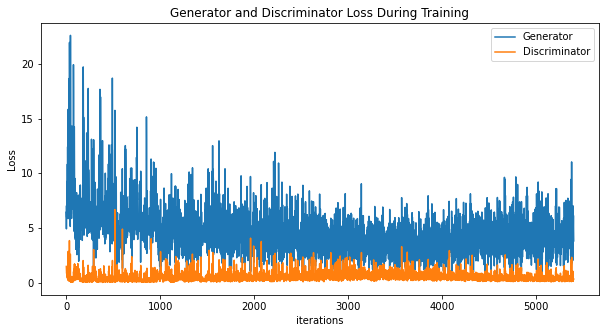

In [52]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

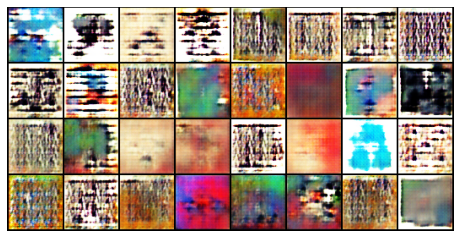

In [54]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())